In [1]:
import yfinance as yf

# download stock data
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2024-11-28")
data = data['Close']  # extract closing price
data = data.asfreq('D').interpolate()  # handle missing values


[*********************100%***********************]  1 of 1 completed


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd

# decompose the time series
decomposition = seasonal_decompose(data, model='additive', period=252)

# check and ensure each component is a pandas.Series
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# ensure each component is a pandas.Series, remove NaN, and adjust the index
trend = pd.Series(trend).dropna()
seasonal = pd.Series(seasonal).dropna()
residual = pd.Series(residual).dropna()
data = data.loc[trend.index]  # align the index of the original data



In [3]:
# combine trend, seasonal, residual, and original data
combined = pd.concat([trend, seasonal, residual, data], axis=1)

print(combined.head())
# define the target variable (the next day's closing price)
combined['target'] = combined['AAPL'].shift(-1)  # the next day's price
combined.dropna(inplace=True)

print(combined.head())

            trend  seasonal  resid  AAPL
Date                                    
2010-01-04    NaN -1.659337    NaN   NaN
2010-01-05    NaN -1.534259    NaN   NaN
2010-01-06    NaN -1.254427    NaN   NaN
2010-01-07    NaN -1.622537    NaN   NaN
2010-01-08    NaN -1.699306    NaN   NaN
               trend  seasonal     resid      AAPL    target
Date                                                        
2010-05-10  8.544874  1.655653 -1.129456  9.071071  9.161429
2010-05-11  8.552436  1.472513 -0.863519  9.161429  9.360357
2010-05-12  8.560438  1.474806 -0.674887  9.360357  9.227143
2010-05-13  8.569313  1.580056 -0.922225  9.227143  9.065000
2010-05-14  8.578481  1.053861 -0.567342  9.065000  9.069762


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# split the data into training and testing sets
X = combined[['trend', 'seasonal', 'resid', 'AAPL']]
y = combined['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# train the random forest model
model = Lasso(alpha=0.01, random_state=42)
model.fit(X_train, y_train)

# predict and evaluate
y_pred = model.predict(X_test)
print(f"mse: {mean_squared_error(y_test, y_pred):.2f}")
print(f"mae: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"r2: {r2_score(y_test, y_pred):.2f}")


mse: 4.85
mae: 1.46
r2: 0.99


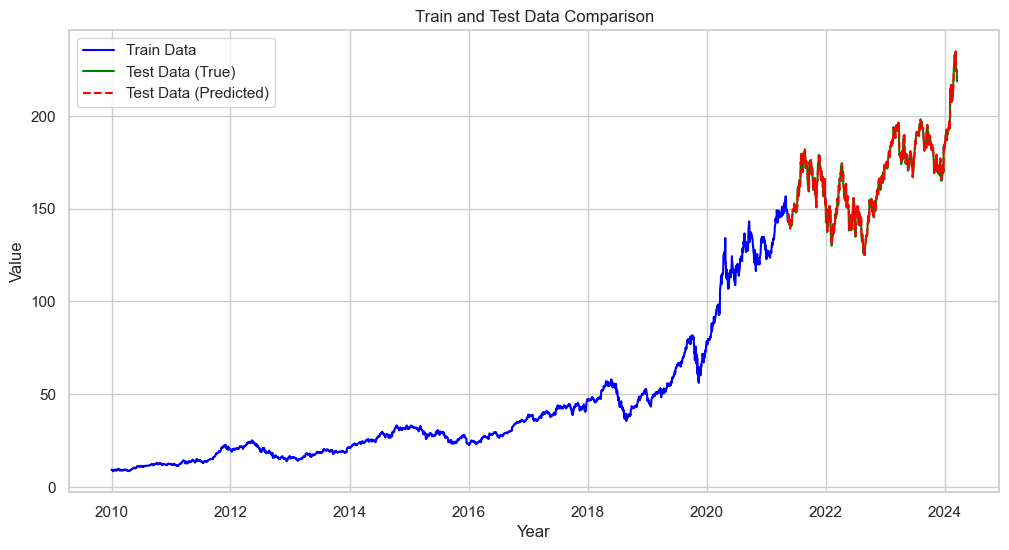

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set Seaborn style
sns.set(style="whitegrid")

# Example date range
date_range_train = pd.date_range(start='2010-01-01', periods=len(y_train), freq='D')
date_range_test = pd.date_range(start=date_range_train[-1] + pd.Timedelta(days=1), periods=len(y_test), freq='D')

# Set Seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(12, 6))

# 1. Plot training data
plt.plot(date_range_train, y_train, label='Train Data', color='blue')

# 2. Plot true test data
plt.plot(date_range_test, y_test, label='Test Data (True)', color='green')

# 3. Plot predicted test data
plt.plot(date_range_test, y_pred, label='Test Data (Predicted)', color='red', linestyle='--')

# Add legend, title, and axis labels
plt.legend()
plt.title('Train and Test Data Comparison')
plt.xlabel('Year')
plt.ylabel('Value')

# Format x-axis to show years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# Show grid
plt.grid(True)

# Show plot
plt.show()


# add the sentiment score

In [6]:
import pandas as pd
df_news = pd.read_csv('../data/AAPL_news_data_sentiment.csv')
df_news.head()



,title,publish_on,author,author_name,sentiment_score,sentiment_label,positive_score,negative_score,Date
0,FTN Midwest: Apple (NASDAQ:AAPL) remains our b...,2008-05-30T10:31:03-04:00,6383,"Eli Hoffmann, SA News Editor",0.918329,1,0.918329,0.000000,2008-05-30
1,Apple's (NASDAQ:AAPL) back-to-school promo wil...,2008-05-30T08:13:35-04:00,6383,"Eli Hoffmann, SA News Editor",0.995474,2,1.990949,0.995474,2008-05-30
2,New iPhone (NASDAQ:AAPL) patents reveal 1) A w...,2008-05-29T13:29:55-04:00,6383,"Eli Hoffmann, SA News Editor",0.999844,1,0.999844,0.000000,2008-05-29
3,Infineon's (IFX -12.85%) warning this morning ...,2008-05-29T11:07:50-04:00,6383,"Eli Hoffmann, SA News Editor",0.998136,0,0.000000,-0.998136,2008-05-29
4,Hutchison Telecom (HTX) to sell iPhone (NASDAQ...,2008-05-29T10:59:38-04:00,6383,"Eli Hoffmann, SA News Editor",0.999879,1,0.999879,0.000000,2008-05-29


In [7]:
combined.reset_index(inplace=True)
combined.rename(columns={'index': 'Date'}, inplace=True)
# Convert Date column to datetime
combined['Date'] = pd.to_datetime(combined['Date'])
df_news['Date'] = pd.to_datetime(df_news['Date'])

merged_df = pd.merge(combined, df_news, on='Date', how='left')
merged_df.dropna(inplace=True)
merged_df.head()


,Date,trend,seasonal,resid,AAPL,target,title,publish_on,author,author_name,sentiment_score,sentiment_label,positive_score,negative_score
0,2010-05-10,8.544874,1.655653,-1.129456,9.071071,9.161429,Android (NASDAQ:GOOG) has passed the iPhone (N...,2010-05-10T11:44:30-04:00,427396.0,"Carl Surran, SA News Editor",0.997832,2.0,1.995664,0.997832
2,2010-05-12,8.560438,1.474806,-0.674887,9.360357,9.227143,"Suit, countersuit: HTC files a complaint with ...",2010-05-12T14:22:53-04:00,543215.0,"Carl Surran, SA News Editor",0.999167,1.0,0.999167,0.000000
3,2010-05-12,8.560438,1.474806,-0.674887,9.360357,9.227143,Verizon (NYSE:VZ) and Google (NASDAQ:GOOG) are...,2010-05-12T08:43:44-04:00,234601.0,"Carl Surran, SA News Editor",0.999851,1.0,0.999851,0.000000
4,2010-05-13,8.569313,1.580056,-0.922225,9.227143,9.065000,"Four tech firms - Apple (NASDAQ:AAPL), Microso...",2010-05-13T14:10:08-04:00,543215.0,"Carl Surran, SA News Editor",0.999896,1.0,0.999896,0.000000
5,2010-05-13,8.569313,1.580056,-0.922225,9.227143,9.065000,Adobe Systems (NASDAQ:ADBE) has taken out news...,2010-05-13T09:53:00-04:00,543215.0,"Carl Surran, SA News Editor",0.998224,1.0,0.998224,0.000000


In [8]:
merged_df['change'] = merged_df['target'] - merged_df['AAPL']
merged_df['change_label'] = np.where(merged_df['change'] > 0, 'positive', 'negative')
merged_df.head()


,Date,trend,seasonal,resid,AAPL,target,title,publish_on,author,author_name,sentiment_score,sentiment_label,positive_score,negative_score,change,change_label
0,2010-05-10,8.544874,1.655653,-1.129456,9.071071,9.161429,Android (NASDAQ:GOOG) has passed the iPhone (N...,2010-05-10T11:44:30-04:00,427396.0,"Carl Surran, SA News Editor",0.997832,2.0,1.995664,0.997832,0.090359,positive
2,2010-05-12,8.560438,1.474806,-0.674887,9.360357,9.227143,"Suit, countersuit: HTC files a complaint with ...",2010-05-12T14:22:53-04:00,543215.0,"Carl Surran, SA News Editor",0.999167,1.0,0.999167,0.000000,-0.133214,negative
3,2010-05-12,8.560438,1.474806,-0.674887,9.360357,9.227143,Verizon (NYSE:VZ) and Google (NASDAQ:GOOG) are...,2010-05-12T08:43:44-04:00,234601.0,"Carl Surran, SA News Editor",0.999851,1.0,0.999851,0.000000,-0.133214,negative
4,2010-05-13,8.569313,1.580056,-0.922225,9.227143,9.065000,"Four tech firms - Apple (NASDAQ:AAPL), Microso...",2010-05-13T14:10:08-04:00,543215.0,"Carl Surran, SA News Editor",0.999896,1.0,0.999896,0.000000,-0.162144,negative
5,2010-05-13,8.569313,1.580056,-0.922225,9.227143,9.065000,Adobe Systems (NASDAQ:ADBE) has taken out news...,2010-05-13T09:53:00-04:00,543215.0,"Carl Surran, SA News Editor",0.998224,1.0,0.998224,0.000000,-0.162144,negative


In [9]:
from sklearn.linear_model import LinearRegression


weight_model = LinearRegression()
weight_model.fit(merged_df[['positive_score', 'negative_score']], merged_df['change'])
print(weight_model.coef_)
print(weight_model.intercept_)

[-0.11912269  0.13014661]
0.15276427737643244


### Analysis of Sentiment Score as a Predictor

This is interesting: the weight of positive sentiment is -0.11, and negative sentiment is 0.14. Here are some reasons why the sentiment score might not be a good predictor:

#### Data Bias
- **Media Bias**: If the data source is biased, such as media tending to report major positive news (which the market has already priced in), positive news might instead correspond to a stock price pullback.
- **Negative News Reaction**: Negative news might trigger market sentiment reactions, but the company could quickly reverse the situation through policy adjustments, leading to a stock price increase.

#### Market Expectations Already Priced In
- **Positive News**: The market may have already anticipated the impact of positive news, leading investors to "sell the news" after its release, resulting in a stock price drop.
- **Negative News**: If the market perceives the impact as overestimated, it could lead to the phenomenon of "bad news is good news."

#### Complex Relationship Between Target Variable and Sentiment Label
- **Sentiment vs. Stock Price**: If your target variable (y) is the `sentiment_label` instead of the actual stock price change, the coefficients may reflect patterns in the sentiment classification rules rather than directly impacting stock prices.


In [11]:
merged_df['weighted_score'] = (
    weight_model.coef_[0] * merged_df['positive_score'] + 
    weight_model.coef_[1] * merged_df['negative_score']
)

In [18]:
merged_df.tail()


,Date,trend,seasonal,resid,AAPL,target,title,publish_on,author,author_name,sentiment_score,sentiment_label,positive_score,negative_score,change,change_label,weighted_score
8203,2023-12-27,180.941052,1.552943,10.655999,193.149994,193.580002,Apple Watch ban paused by appeals court; Apple...,2023-12-27T17:24:59-05:00,59008794.0,"Ravikash Bakolia, SA News Editor",0.999672,1.0,0.999672,0.00000,0.430008,positive,-0.119084
8204,2023-12-27,180.941052,1.552943,10.655999,193.149994,193.580002,Amazon Prime is getting ads. How does it stack...,2023-12-27T13:59:02-05:00,55407719.0,"Ravikash Bakolia, SA News Editor",0.999854,1.0,0.999854,0.00000,0.430008,positive,-0.119105
8205,2023-12-27,180.941052,1.552943,10.655999,193.149994,193.580002,Apple iPhone design chief said to join Jony Iv...,2023-12-27T07:30:27-05:00,55407719.0,"Ravikash Bakolia, SA News Editor",0.999845,1.0,0.999845,0.00000,0.430008,positive,-0.119104
8206,2023-12-28,180.910952,1.400339,11.268710,193.580002,192.529999,Apple mulls long-term software fix for watches...,2023-12-28T12:08:35-05:00,54324280.0,"Ravikash Bakolia, SA News Editor",0.997425,1.0,0.997425,0.00000,-1.050003,negative,-0.118816
8207,2023-12-29,180.913770,1.336182,10.280047,192.529999,190.807499,Huawei eyes over $98B in revenue in 2023 as de...,2023-12-29T05:51:27-05:00,54324280.0,"Ravikash Bakolia, SA News Editor",0.999650,2.0,1.999299,0.99965,-1.722500,negative,-0.108061


In [13]:
# save the merged data
merged_df.to_csv('../data/AAPL_trend_seasonal_residual_data_sentiment.csv', index=False)


In [14]:
# split the data into training and testing sets
X = merged_df[['trend', 'seasonal', 'resid', 'AAPL', 'weighted_score']]
y = merged_df['target']
X_merged_train, X_merged_test, y_merged_train, y_merged_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# train the random forest model
model = Lasso(alpha=0.01, random_state=42)
model.fit(X_merged_train, y_merged_train)

# predict and evaluate
y_merged_pred = model.predict(X_merged_test)
print(f"mse: {mean_squared_error(y_merged_test, y_merged_pred):.2f}")
print(f"mae: {mean_absolute_error(y_merged_test, y_merged_pred):.2f}")
print(f"r2: {r2_score(y_merged_test, y_merged_pred):.2f}")

mse: 7.54
mae: 1.85
r2: 0.97


In [15]:
#save the model
import joblib
joblib.dump(model, '../models/AAPL_trend_seasonal_residual_data_sentiment_model.pkl')

['../models/AAPL_trend_seasonal_residual_data_sentiment_model.pkl']